In [1]:
import os
import lightgbm as lgb

import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
import os, gc, pickle

In [2]:
DATA_DIR = "/Users/xzeng/Desktop/kaggle/open-problems-multimodal"

FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [3]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

## loading the common meta data table

In [4]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_multi.shape

(161877, 5)

In [5]:
df_cell_multi.head(5)

,cell_id,day,donor,cell_type,technology
119651,458c2ae2c9b1,2,27678,hidden,multiome
119652,01a0659b0710,2,27678,hidden,multiome
119653,028a8bc3f2ba,2,27678,hidden,multiome
119654,7ec0ca8bb863,2,27678,hidden,multiome
119655,caa0b0022cdc,2,27678,hidden,multiome


(15000, 228942)
(15000, 228054)
(15000, 228054)


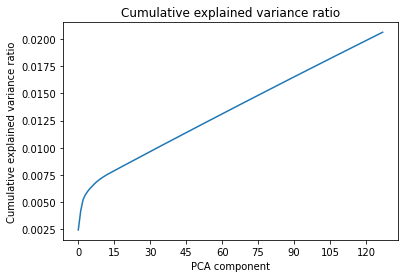

(15000, 128)
multi train x (15000, 128)
multi train y (15000, 23418)


In [7]:
#%%time
# Preprocessing

class PreprocessMultiome(BaseEstimator, TransformerMixin):
    columns_to_use = slice(10000, 14000)
    
    @staticmethod
    def take_column_subset(X):
        return X[:,PreprocessMultiome.columns_to_use]
    
    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessMultiome.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
      #  X = PreprocessMultiome.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca  = TruncatedSVD(n_components=128, random_state=42)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessMultiome()

multi_train_x = None
start, stop = 0, 15000
multi_train_x = preprocessor.fit_transform(pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS,start=start, stop=stop).values)

multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=start, stop=stop)
y_columns = multi_train_y.columns
multi_train_y = multi_train_y.values
print('multi train x',multi_train_x.shape)
print('multi train y',multi_train_y.shape)

In [8]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(multi_train_x)):
    model = None
    gc.collect()
    X_tr = multi_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = multi_train_y[idx_tr]
    del idx_tr

    model = Ridge(copy_X=False)
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = multi_train_x[idx_va]
    y_va = multi_train_y[idx_va]
    del idx_va
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}{multi_train_x.shape} Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

Fold 0: mse = 2.02904, corr =  0.670
Fold 1: mse = 2.02453, corr =  0.672
Fold 2: mse = 2.02595, corr =  0.672
Fold 3: mse = 2.02403, corr =  0.672
Fold 4: mse = 2.03089, corr =  0.671
(15000, 128) Average  mse = 2.02689; corr = 0.671
CPU times: user 1min 6s, sys: 10.1 s, total: 1min 16s
Wall time: 32 s


In [9]:
multi_train_x_pd = pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS, start=start, stop=stop)

In [10]:
multi_train_x_pd.head(5)

gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
56390cf1b95e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.428336,0.0,0.0,0.0,0.0
fc0c60183c33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9b4a87e22ad0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
81cccad8cd81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
15cb3d85c232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [11]:
files = open('../results/dna2vec_sequence_embed.pkl', 'rb')
regions_vec = pickle.load(files)

In [12]:
multi_train_x_pd = multi_train_x_pd[list(regions_vec.keys())]

In [13]:
peak_names = multi_train_x_pd.columns.tolist()

for x in range(len(peak_names)):
    if x == 0 :
        vec_array = regions_vec[peak_names[x]]
    else:
        vec_array = np.vstack((vec_array, regions_vec[peak_names[x]]))

In [14]:
vec_array.shape

(228942, 128)

In [15]:
multi_train_x_array = multi_train_x_pd.values
multi_train_x_array_merge = np.dot(multi_train_x_array,vec_array) 
multi_train_x_array_merge.shape

(15000, 128)

In [ ]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(multi_train_x_array_merge)):
    model = None
    gc.collect()
    X_tr = multi_train_x_array_merge[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = multi_train_y[idx_tr]
    del idx_tr

    model = Ridge(copy_X=False)
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = multi_train_x_array_merge[idx_va]
    y_va = multi_train_y[idx_va]
    del idx_va
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}{multi_train_x_array_merge.shape} Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

In [14]:
x = np.array([[1,2]])
y = np.array([[1],[2]])

In [18]:
np.dot(y,x)

array([[1, 2],
       [2, 4]])